#### __17. 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습__

In [1]:
import os
import sys
 
import sklearn
import tensorflow as tf

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

오토인코더는 단순히 입력을 출력으로 복사하는 방법을 배운다. <br>
네트워크에 제약을 가해 이 작업을 어렵게 하는데, 잠재 표현의 크기를 제한하거나(은닉층의 뉴런 수를 입력층보다 적게 함) <br>
입력에 잡음을 추가하고 원본 입력을 복원하도록 네트워크를 훈련할 수 있다. <br>
입력을 내부 표현으로 바꾸는 인코더(인지 네트워크)와 내부 표현을 출력으로 바꾸는 디코더(생성 네트워크)로 구성된다.

__17.2 과소완전 선형 오토인코더로 PCA 수행하기__

In [2]:
np.random.seed(42)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
X_train[:3, :]

array([[ 0.54713696,  0.48246774,  0.2782722 ],
       [-1.23318464, -0.67735508, -0.30276632],
       [-1.06595173,  0.05100107, -0.02660826]])

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 4ms/step - loss: 0.4243
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1695
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1445
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1086
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 13/20
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


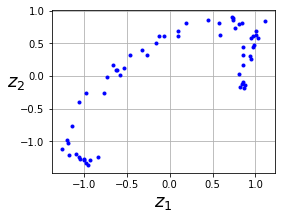

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

__17.3 적층 오토인코더(stacked autoencoder)__

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
# 적층 오토인코더 구현: 일반적으로 가운데 은닉층(코딩층)을 기준으로 대칭
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3353 - rounded_accuracy: 0.8896 - val_loss: 0.3114 - val_rounded_accuracy: 0.9126
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3043 - rounded_accuracy: 0.9164 - val_loss: 0.3013 - val_rounded_accuracy: 0.9216
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2974 - rounded_accuracy: 0.9226 - val_loss: 0.2962 - val_rounded_accuracy: 0.9235
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2934 - rounded_accuracy: 0.9264 - val_loss: 0.2930 - val_rounded_accuracy: 0.9293
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2909 - rounded_accuracy: 0.9285 - val_loss: 0.2908 - val_rounded_accuracy: 0.9298
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2889 - rounded_accuracy: 0.9303 - val_loss: 0.2902 - val_rounded_accuracy: 0.9318
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 15ms/step


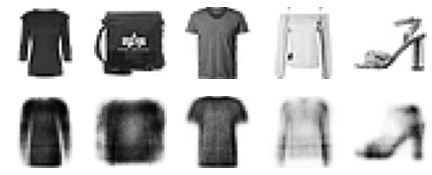

In [16]:
# 재구성 시각화
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5 ,3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

In [18]:
# 패션 MNIST 데이터셋 시각화
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max()- X_valid_2D.min())

157/157 [==============================] - 0s 1ms/step


c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


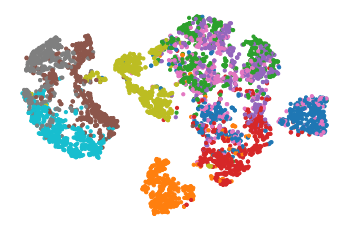

In [19]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

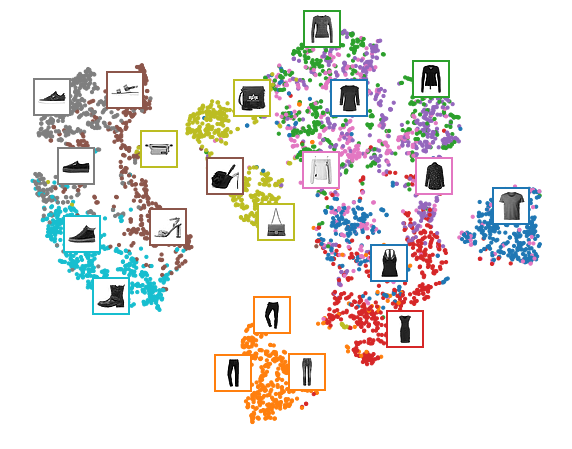

In [24]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [29]:
# 가중치 묶기: 대칭적인 특성을 이용하여 가중치를 재정의
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
    
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [30]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [33]:
tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2966 - rounded_accuracy: 0.9230 - val_loss: 0.2985 - val_rounded_accuracy: 0.9164
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2913 - rounded_accuracy: 0.9280 - val_loss: 0.2967 - val_rounded_accuracy: 0.9289
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2882 - rounded_accuracy: 0.9308 - val_loss: 0.2918 - val_rounded_accuracy: 0.9232
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2864 - rounded_accuracy: 0.9326 - val_loss: 0.2858 - val_rounded_accuracy: 0.9348
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2850 - rounded_accuracy: 0.9339 - val_loss: 0.2860 - val_rounded_accuracy: 0.9324
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2840 - rounded_accuracy: 0.9348 - val_loss: 0.2853 - val_rounded_accuracy: 0.9333
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 50ms/step


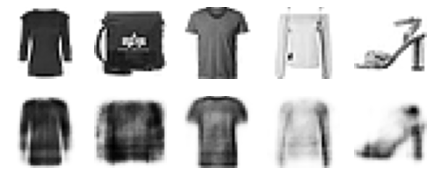

In [34]:
show_reconstructions(tied_ae)
plt.show()